# Homework 2 Exercise 2
From the Howell1 dataset, consider only the people younger than 13 years
old. Estimate the causal association between age and weight. Assume that
age influences weight through two paths. First, age influences height, and
height influences weight. Second, age directly influences weight through age-
related changes in muscle growth and body proportions. All of this implies
this causal model (DAG):

In [1]:
# A -> W
# |    ^
# |   /
# |  /
# v /
# H

Use a linear regression to estimate the total (not just direct) causal effect of
each year of growth on weight. Be sure to carefully consider the priors. Try
using prior predictive simulation to assess what they imply.

In [2]:
using StatsPlots
using StatisticalRethinking: sr_datadir, PI
using StatisticalRethinkingCommon
using Statistics, StatsBase
import CSV
using DataFrames
using Gen, Distributions

In [3]:
@time data = CSV.read(sr_datadir("Howell1.csv"), DataFrame)

 10.302358 seconds (3.00 M allocations: 136.124 MiB, 0.31% gc time, 99.97% compilation time)


,height,weight,age,male
,Float64,Float64,Float64,Int64
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


In [4]:
children = data[data.age .< 13 , :]

,height,weight,age,male
,Float64,Float64,Float64,Int64
1,121.92,19.6179,12.0,1
2,105.41,13.948,8.0,0
3,86.36,10.4893,6.5,0
4,109.22,15.9891,7.0,0
5,114.3,17.8602,11.0,1
6,121.92,20.4116,8.0,1
7,128.905,23.36,12.0,0
8,97.79,13.2676,5.0,0
9,110.49,15.4221,9.0,0


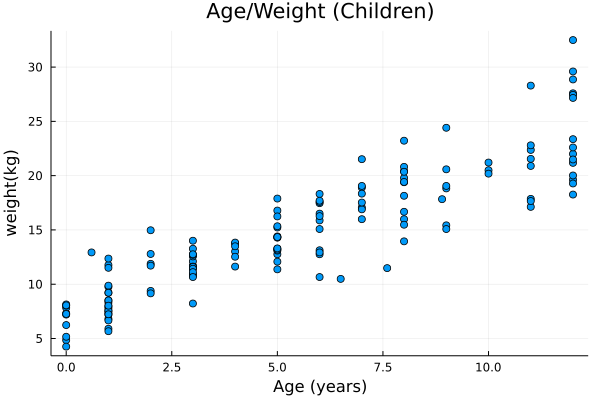

In [5]:
@df children plot(:age, :weight, seriestype=:scatter, title="Age/Weight (Children)", xlabel="Age (years)", ylabel="weight(kg)", legend=false)

In [6]:
dt = standardize_column!(children, :age, scale=false)

ZScoreTransform{Float64, Vector{Float64}}(1, 1, [5.401369863013698], Float64[])

In [7]:
@gen function children_age_weight_model(ages)
    a ~ normal(12., 7.5) # somewhere around 12, in kg
    b ~ gamma(0.25, 4.) # how does weight scale with height, in kg/cm. However, don't forget that height was normalized.
    noise ~ gamma(1., 1.) # how far does the regression stray from reality
    
    function f(age)
        return a + b * age
    end
    
    for (i,age) in enumerate(ages)
        {(:y, i)} ~ normal(f(age), noise)
    end
    return f
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##children_age_weight_model#280", Bool[0], false)

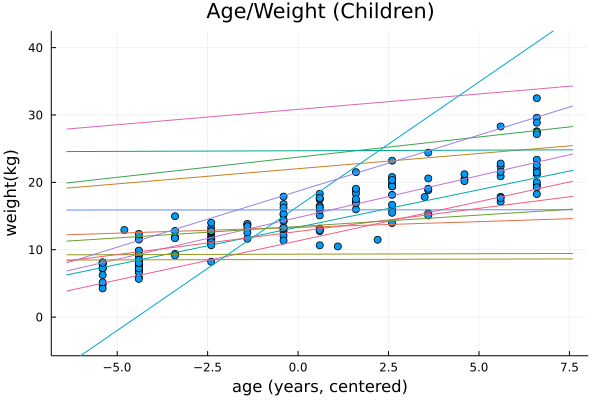

In [8]:
@df children plot(:age, :weight, seriestype=:scatter, title="Age/Weight (Children)", xlabel="age (years, centered)", ylabel="weight(kg)", legend=false)
priors = [children_age_weight_model(()) for _ in 1:15]
test_xs = range(minimum(children.age)-1, maximum(children.age)+1, length=1000)
plot!(test_xs, [f.(test_xs) for f in priors], legend=false)
plot!(ylim=(minimum(children.weight) - 10, maximum(children.weight) + 10))

In [9]:
observations = Gen.choicemap()
for (i,weight) in enumerate(children.weight)
    observations[(:y, i)] = weight
end

@time traces = sampling(children_age_weight_model, (children.age,), observations, steps=1_000, samples=100)

  7.222959 seconds (185.79 M allocations: 6.553 GiB, 10.66% gc time, 6.47% compilation time)


1000-element Vector{Any}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##children_age_weight_model#280", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:y, 14) => Gen.ChoiceOrCallRecord{Float64}(17.463292, -3.2080151962348644, NaN, true), (:y, 46) => Gen.ChoiceOrCallRecord{Float64}(20.808533, -4.1021697041760685, NaN, true), (:y, 50) => Gen.ChoiceOrCallRecord{Float64}(15.989118, -2.9039566294403047, NaN, true), (:y, 123) => Gen.ChoiceOrCallRecord{Float64}(12.757275, -2.599829523093634, NaN, true), (:y, 73) => Gen.ChoiceOrCallRecord{Float64}(17.066399, -3.110349839892371, NaN, true), (:y, 3) => Gen.ChoiceOrCallRecord{Float64}(10.489315, -2.58811477123203, NaN, true), (:y, 129) => Gen.ChoiceOrCallRecord{Float64}(21.54562, -4.288089044214446, NaN, true), (:y, 29) => Gen.ChoiceOrCallRecord{Float64}(19.787951, -3.776292972595509,

In [10]:
params = (:a, :b, :noise)

@time inferred,logweight = infer(traces, children_age_weight_model, (children.age,), (:a, :b, :noise))
a = inferred[:a]
b = inferred[:b]
noise = inferred[:noise]
@info "Parameters:" a b noise

  0.540586 seconds (2.05 M allocations: 149.117 MiB, 99.37% compilation time)


┌ Info: Parameters:
│   a = 14.460637955949295
│   b = 0.9660968425011204
│   noise = 3.1917979558098755
└ @ Main In[10]:7


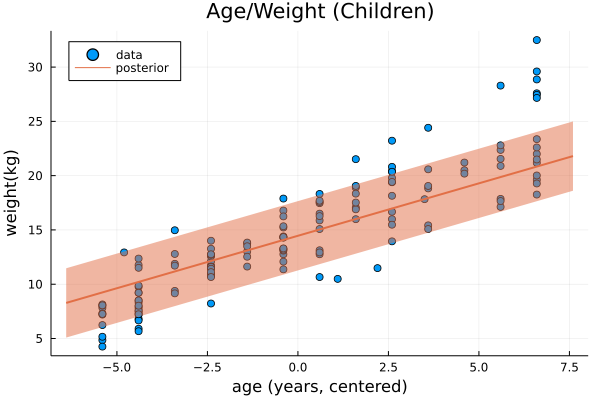

In [11]:
@df children plot(:age, :weight, seriestype=:scatter, title="Age/Weight (Children)", xlabel="age (years, centered)", ylabel="weight(kg)", labels="data", legend=:topleft)
plot!(test_xs, (@. a + b * test_xs), linewidth=2., ribbon=noise, labels="posterior")

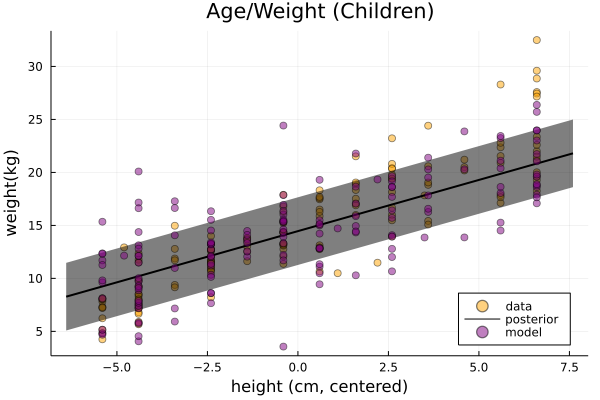

In [12]:
@df children plot(:age, :weight, seriestype=:scatter, color=:orange, alpha=1/2, title="Age/Weight (Children)", xlabel="height (cm, centered)", ylabel="weight(kg)", labels="data", legend=:bottomright)
plot!(test_xs, (@. a + b * test_xs), color=:black, ribbon=noise, labels="posterior", linewidth=2.)
test_predictions = @. rand(Normal(a + b * children.age, noise))
plot!(children.age, test_predictions, seriestype=:scatter, color=:purple, alpha=1/2, label="model")